# Estimate multivariate time series models on real world data

We use quarterly Euro Area rgdp (rGDP) and industrial production index (IP). Euro area rGDP guides government budgets, investment decisions by multinationals, affects stock markets,... Unfortunately it is released with a delay. First estimate of EA rgdp is available with a delay of 80-90 days. IP on the other hand is released with a delay of approx. 30 days. In addition, industrial production represents a large share of rGDP. Therefore it makes sense to utilize IP to predict rGDP. Or, you might be told that IP decreased by 15% due to gas shortages and need to predict what this will do to rGDP.  

Ex. 1 
1. Import data and plot them.   
2. Perform stationarity tests and decide if data should be differenced or in levels. 
3. Calculate correlations between LUXX and the remaining 3 stock indices. Which of the series is the most proimising? 
4. Estimate a VAR on the two selected series. Estimation sample: up to 2021, forecast sample: Jan-June. 
5. Perform a rolling 1-step ahead forecast and plot. 
6. Perform cointegration tests. If cointegration is detected, estimate the model in levels and perform the same forecasts. [SKIP]  

In [1]:
# Ex 1 Import data and plot them
# install required by using (ex.): pip install openpyxl
# initialize packages
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

# import 
os.chdir('C:\\Users\\xct385\\Desktop\\DS ws\\MADS_win25\\Exercises\\2_Ex_MULTI_TS\\Ex_models_python') # set working directory to file's location
df = pd.read_excel('data_ea.xlsx')                              # import excel file data
df["date"] = pd.to_datetime(df["date"]).dt.date
df.dropna(inplace=True);

Comment on the figures. Do indexes look stationary? Can you detect common patterns by eyeballing the figures?


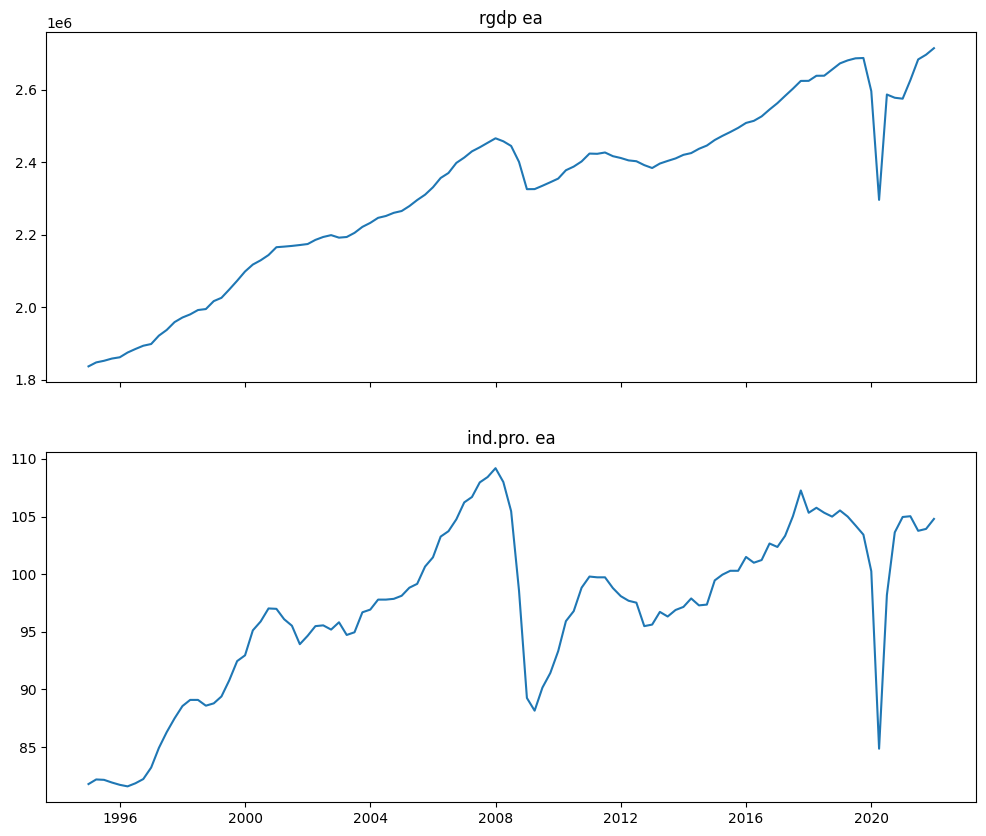

In [2]:
# plot data
fig, axs = plt.subplots(2,1, sharex=True,figsize=(12,10))
axs[0]
axs[0].plot(df['date'], df['rgdp_ea']);
axs[0].set_title('rgdp ea');
axs[1].plot(df['date'], df['indpro_ea']);
axs[1].set_title("ind.pro. ea");
print("Comment on the figures. Do indexes look stationary? Can you detect common patterns by eyeballing the figures?")


From the looks of AC and PAC all indexes, except luxx, are clearly non-stationary (very persistent AC function, PAC cuts off at lag 1). Luxx AC function is less persistent so it could be either stationary or non-stationary.


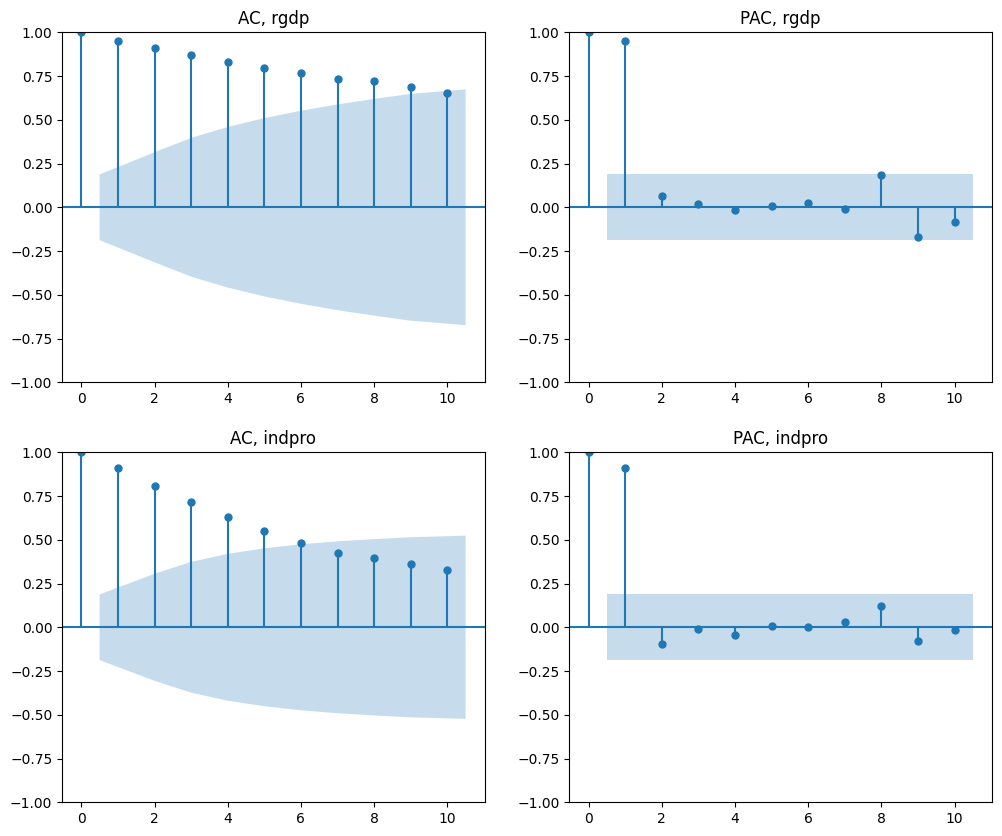

In [3]:
# Ex 2 stationarity
# plot AC and PAC functions
fig, axs = plt.subplots(2, 2,figsize=(12,10))
# luxx
sm.graphics.tsa.plot_acf(df["rgdp_ea"], lags=10, ax=axs[0,0]);
axs[0,0].set_title("AC, rgdp");
sm.graphics.tsa.plot_pacf(df["rgdp_ea"], lags=10, ax=axs[0,1]);
axs[0,1].set_title("PAC, rgdp");
# dax
sm.graphics.tsa.plot_acf(df["indpro_ea"], lags=10, ax=axs[1,0]);
axs[1,0].set_title("AC, indpro");
sm.graphics.tsa.plot_pacf(df["indpro_ea"], lags=10, ax=axs[1,1]);
axs[1,1].set_title("PAC, indpro");


print("From the looks of AC and PAC all indexes, except luxx, are clearly non-stationary (very persistent AC function, PAC cuts off at lag 1). Luxx AC function is less persistent so it could be either stationary or non-stationary.")


In [4]:
# Ex 2 stationarity
# Stationarity tests - table with probabilities for each test
ur_probs = pd.DataFrame(np.zeros((2,2)))
ur_probs.index = ['rgdp_ea','indpro']
ur_probs.columns = ['adf','kpss']

# tests
for i in range(1, df.shape[1]):
    res = sm.tsa.stattools.adfuller(df.iloc[:,i].dropna(),maxlag=14,regression='c',autolag='AIC');
    ur_probs.iloc[i-1,0] = res[1]
    res = sm.tsa.stattools.kpss(df.iloc[:,i].dropna(),regression='c',nlags='auto');
    ur_probs.iloc[i-1,1] = res[1]

display("Table with p-values for ADF (H0:series is UR) and KPSS (H0:series is stat)")
print(ur_probs)

C:\Users\xct385\AppData\Local\Temp\1\ipykernel_1776\1438806787.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = sm.tsa.stattools.kpss(df.iloc[:,i].dropna(),regression='c',nlags='auto');
C:\Users\xct385\AppData\Local\Temp\1\ipykernel_1776\1438806787.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = sm.tsa.stattools.kpss(df.iloc[:,i].dropna(),regression='c',nlags='auto');


'Table with p-values for ADF (H0:series is UR) and KPSS (H0:series is stat)'

              adf  kpss
rgdp_ea  0.107836  0.01
indpro   0.641490  0.01


Comment on the figures. Do indexes look stationary? Can you detect common patterns by eyeballing the figures? If not, why not?


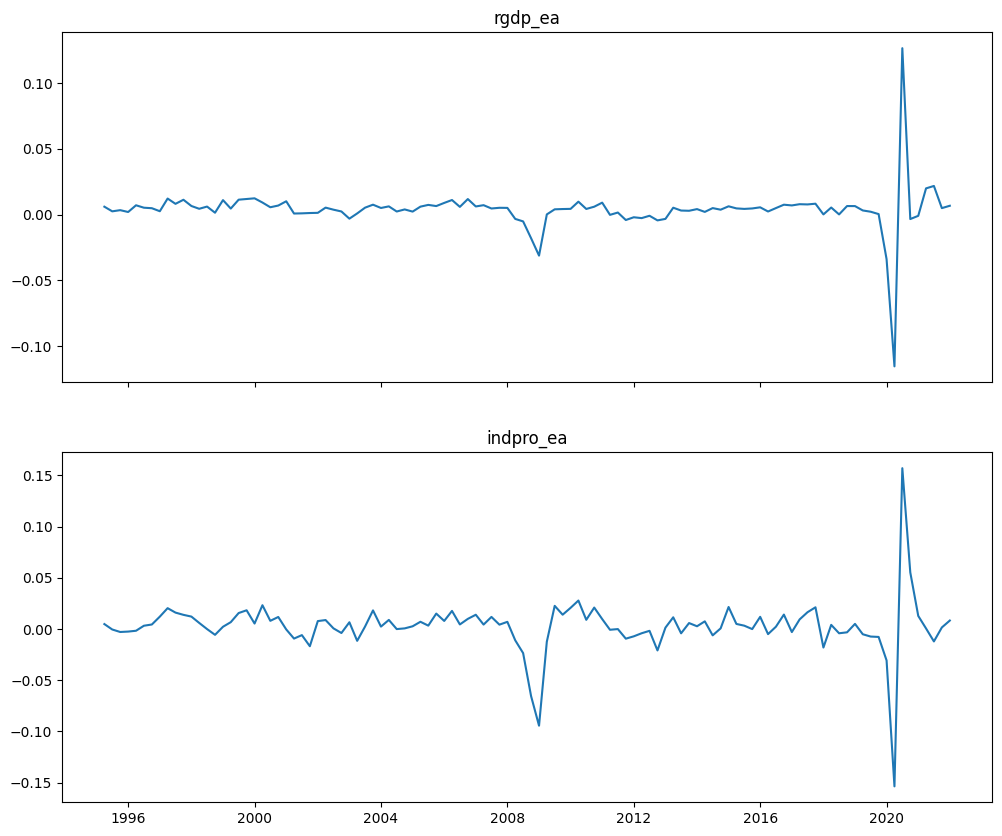

In [5]:
# both are non-stationary. 

# Difference the series and re-check 
df_diff = pd.DataFrame.pct_change(df.iloc[:,1:])
df_diff.index = pd.to_datetime(df["date"]).dt.date
#df_diff['date'] = df['date']
df_diff = df_diff.dropna()



# PLOT SERIES
fig, axs = plt.subplots(2,1, sharex=True,figsize=(12,10))
axs[0].plot( df_diff['rgdp_ea']);
axs[0].set_title('rgdp_ea');
axs[1].plot( df_diff['indpro_ea']);
axs[1].set_title("indpro_ea");
print("Comment on the figures. Do indexes look stationary? Can you detect common patterns by eyeballing the figures? If not, why not?")



C:\Users\xct385\AppData\Local\Temp\1\ipykernel_1776\2179448355.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_diff.rgdp_ea, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3}, ax=axs[0])
C:\Users\xct385\AppData\Local\Temp\1\ipykernel_1776\2179448355.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de441

<Axes: xlabel='indpro_ea', ylabel='Density'>

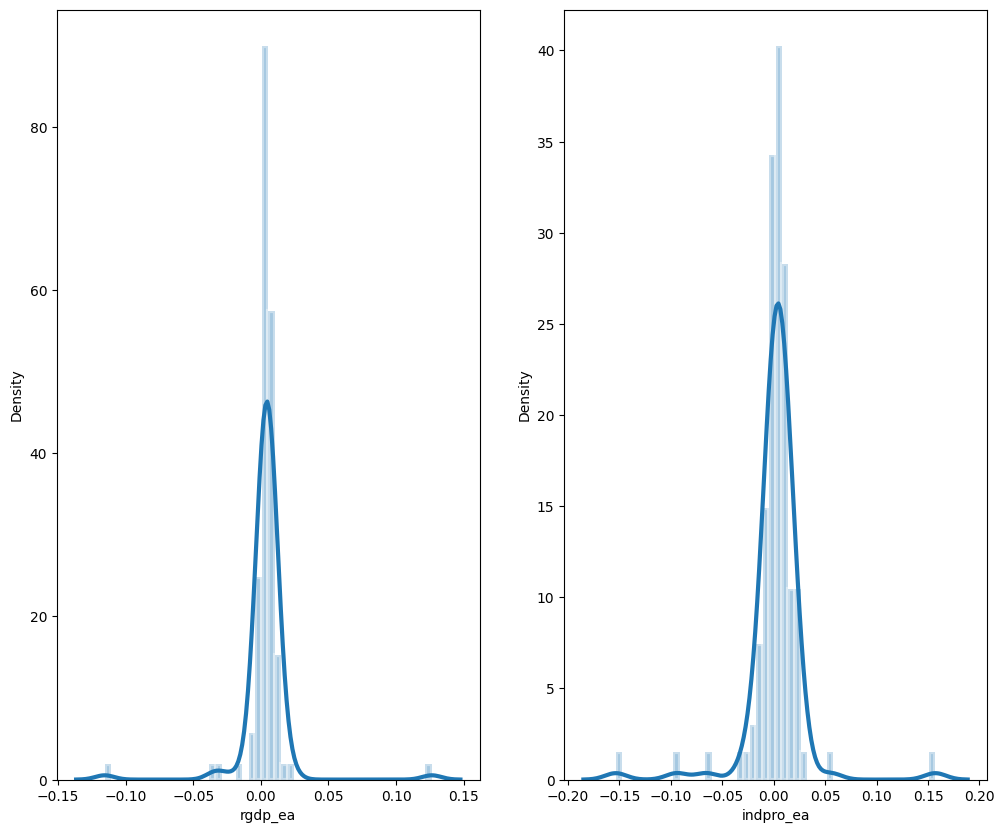

In [6]:
# The series probably hace outliers related to Covid-19 and (perhaps) 2007 financial crissis. Let's plot a histogram
# histogram and kernel density estimation function of the variable height
# pip install seaborn
import seaborn as sns

#histogram with kernel density
fig, axs = plt.subplots(1,2,figsize=(12,10))
sns.distplot(df_diff.rgdp_ea, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3}, ax=axs[0])
sns.distplot(df_diff.indpro_ea, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3}, ax=axs[1])


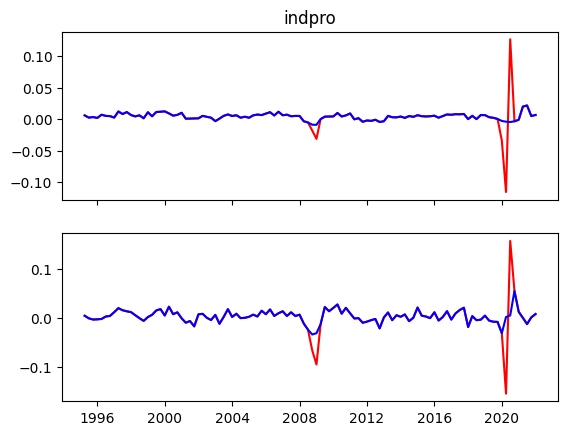

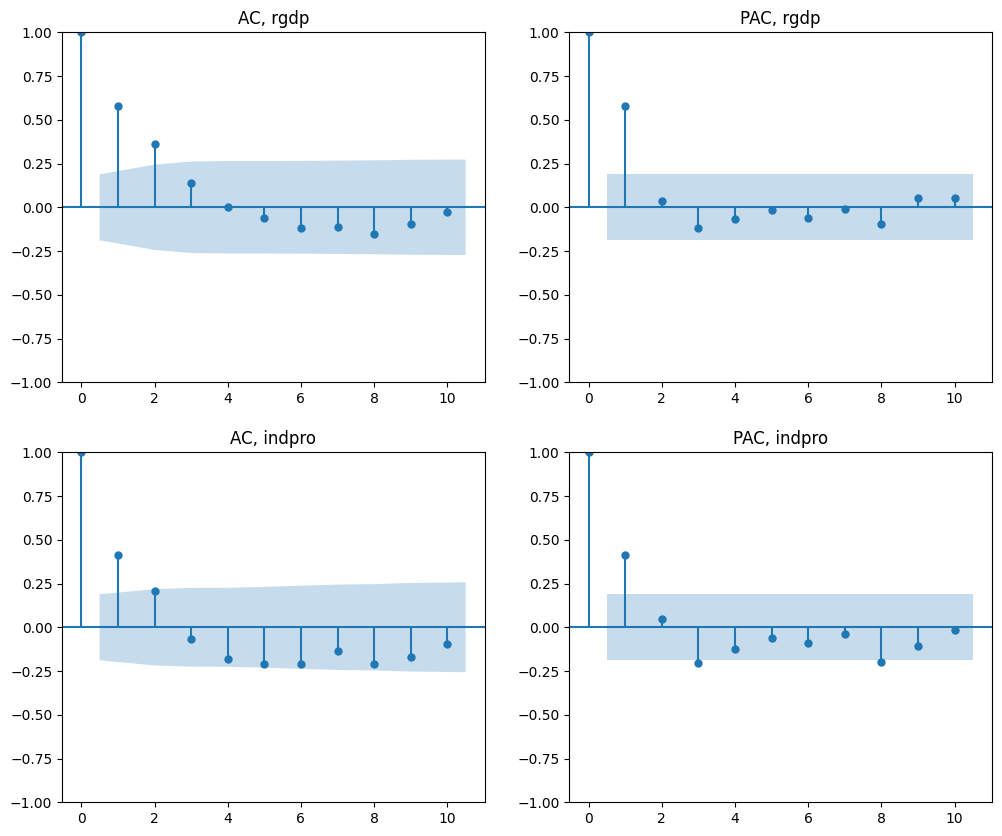

In [12]:
# Since the series contain outliers we smooth the for the purpose of AC and PAC estimation 

# Identify outliers & replace outliers. Many methods are available (visual analysis, iqr range, regression,..). 
# We replace values that are k-times inter-quartile range away from upper and lower quartile (standard rule of thumb). We replace it with a
# n-observations two-sided rolling averge (preserves dynamics but attenuates peaks)   
# Let's define a function for this purpose. We assume data is pandas df.  
def smooth_outliers(df,k,n):
    out = df.copy()               # copy current column 
    # loop over variables
    for col in df:                                    # loop over columns
        if pd.api.types.is_numeric_dtype(df[col]):    # if column is numeric
                # quartiles and inter-quartile range
                q1 = df[col].quantile(0.25)           # Q1
                q3 = df[col].quantile(0.75)           # Q3
                iqr = q3-q1                           # IQR
                ind = ~out[col].between(q1-k*iqr, q3+k*iqr, inclusive='both')               # logical index for outliers in df[col]
                col_sm = df[col].rolling(window=n,center=True,min_periods=None).mean()                      # smooth with rolling window 
                out.loc[ind,col] = col_sm[ind]                                             # replace outliers with two-sided rolling mean
                # col_sm = np.array(sm.tsa.filters.hpfilter(df[col],0.5)).transpose()      # smooth with hp filter 
                # ret.loc[ind,col] = col_sm[ind,1]                                         # replace outliers with hp trend
                
    return out

df_diff_sm = smooth_outliers(df_diff,4,6)

# plot
fig, ax = plt.subplots(2,1,sharex = True)
ax[0].plot(df_diff['rgdp_ea'],'-r')
ax[0].plot(df_diff_sm['rgdp_ea'],'-b')
ax[0].set_title('rgdp')

ax[1].plot(df_diff['indpro_ea'],'-r')
ax[1].plot(df_diff_sm['indpro_ea'],'-b')
ax[0].set_title('indpro')


# plot AC and PAC functions
fig, axs = plt.subplots(2, 2,figsize=(12,10))
# luxx
sm.graphics.tsa.plot_acf(df_diff_sm["rgdp_ea"], lags=10, ax=axs[0,0]);
axs[0,0].set_title("AC, rgdp");
sm.graphics.tsa.plot_pacf(df_diff_sm["rgdp_ea"], lags=10, ax=axs[0,1]);
axs[0,1].set_title("PAC, rgdp");
# dax
sm.graphics.tsa.plot_acf(df_diff_sm["indpro_ea"], lags=10, ax=axs[1,0]);
axs[1,0].set_title("AC, indpro");
sm.graphics.tsa.plot_pacf(df_diff_sm["indpro_ea"], lags=10, ax=axs[1,1]);
axs[1,1].set_title("PAC, indpro");


In [13]:
# Select VAR order
Y = sm.tsa.VAR(df_diff)
res = sm.tsa.VAR.select_order(Y,5)
res.summary()
# We rely on BIC and HQIC and select p = 1

# # Same procedure on data with outliers
# Y = sm.tsa.VAR(df_diff)
# res = sm.tsa.VAR.select_order(Y,5)
# res.summary()

# See also UR tests
# Stationarity tests - table with probabilities for each test
# ur_probs = pd.DataFrame(np.zeros((2,2)))
# ur_probs.index = ['rgdp','indpro']
# ur_probs.columns = ['adf_diff','kpss']
# 
# # tests
# for i in range(0, df_diff_sm.shape[1]-1):
#     res = sm.tsa.stattools.adfuller(df_diff_sm.iloc[:,i].dropna(),maxlag=14,regression='c',autolag='AIC');
#     ur_probs.iloc[i,0] = res[1]
#     res = sm.tsa.stattools.kpss(df_diff_sm.iloc[:,i].dropna(),regression='c',nlags='auto');
#     ur_probs.iloc[i,1] = res[1]

# display("Table with p-values for Adf_diff (H0:series is UR) and KPSS (H0:series is stat)")
# print(ur_probs)
# print("It appears that all series are now stationary.")
 
 

c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-16.72,-16.67,5.451e-08,-16.70
1,-17.03,-16.87,4.034e-08,-16.96
2,-17.18,-16.92*,3.473e-08,-17.07*
3,-17.20*,-16.85,3.379e-08*,-17.06
4,-17.19,-16.73,3.410e-08,-17.01
5,-17.17,-16.60,3.510e-08,-16.94


In [14]:
# Ex 5: Perform rolling one-step-ahead forecast 
# Let's first move the date into index
# df_diff.index = df.index[1:]
Y = df_diff_sm[['rgdp_ea','indpro_ea']]
n_fcs = 40
n = Y.shape[0] 
fcs = np.empty((n_fcs,2,))
fcs[:] = np.nan
for i in range(0,n_fcs):                          # loop for 1-step-ahead forecasts on the last 10% of the data
    
    var_i   = sm.tsa.VAR(Y[0:(n-(n_fcs-i))])      # declare var model object
    mdl_i   = var_i.fit(2)                        # fit var model
    fcs_i   = mdl_i.forecast(y=np.array(df_diff.iloc[0:(n-(n_fcs-i)),:]), steps=1); # one-step-ahead forecast
    fcs[i,:] = fcs_i                              # store the forecast



c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

In [15]:
y_var   = sm.tsa.VAR(Y)      # declare var model object
mdl   = y_var.fit(1)    


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Do the forecasts seem precise? Better than the stock market data! Still, what happens at turning points?


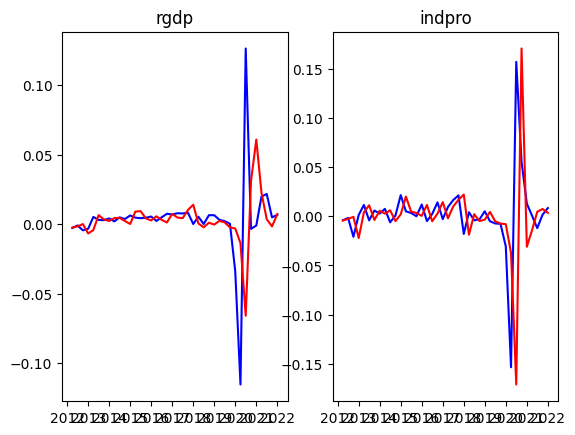

In [16]:
# y corresponding to forecasted values
y_true = df_diff.iloc[n-n_fcs:n+1,df_diff.columns.get_indexer(['rgdp_ea','indpro_ea'])]
fcs = pd.DataFrame(fcs)
fcs.index = y_true.index
fcs.columns  = y_true.columns

# plot true and forecasted 
fig, axs = plt.subplots(1,2)
axs[0].plot(y_true['rgdp_ea'],'b-')
axs[0].plot(fcs['rgdp_ea'],'r-')
axs[0].set_title('rgdp')
axs[1].plot(y_true['indpro_ea'],'b-')
axs[1].plot(fcs['indpro_ea'],'r-')
axs[1].set_title('indpro')

print("Do the forecasts seem precise? Better than the stock market data! Still, what happens at turning points?")





In-sample fit as well as forecasts look better now. The reason is that the two series exhibit higher persistence as as they are better correlated.
See also model coefficients on own first lags (good indication of the level of persistence).


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Oct, 2023
Time:                     13:54:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -19.8902
Nobs:                     107.000    HQIC:                  -19.9793
Log likelihood:           774.490    FPE:                1.98029e-09
AIC:                     -20.0401    Det(Omega_mle):     1.87374e-09
--------------------------------------------------------------------
Results for equation rgdp_ea
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.001848         0.000508            3.638           0.000
L1.rgdp_ea           0.491775         0.087835            5.599           0.000
L1.indpro_ea         0.076442         0.034967            2.18

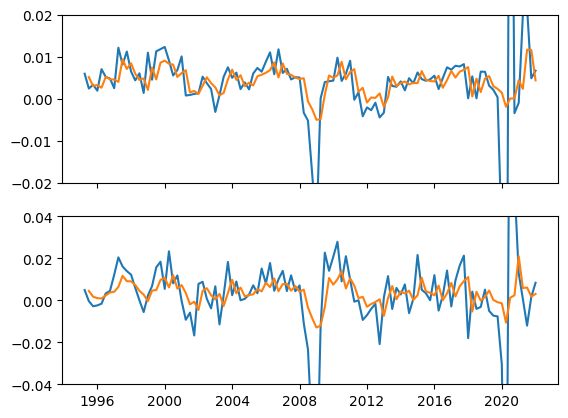

In [17]:
# Let's check the full sample in-sample fit

var_full   = sm.tsa.VAR(Y)
res   = var_full.fit(1)


f, axs = plt.subplots(2, sharex=True)
axs[0].plot(Y.index, df_diff['rgdp_ea'])
axs[0].plot(res.fittedvalues.index, res.fittedvalues['rgdp_ea'])
axs[0].set_ylim([-0.02,+0.02])
axs[1].plot(Y.index, df_diff['indpro_ea'])
axs[1].plot(res.fittedvalues.index, res.fittedvalues['indpro_ea'])
axs[1].set_ylim([-0.04,+0.04])

print('In-sample fit as well as forecasts look better now. The reason is that the two series exhibit higher persistence as as they are better correlated.')
print('See also model coefficients on own first lags (good indication of the level of persistence).')
res.summary()


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


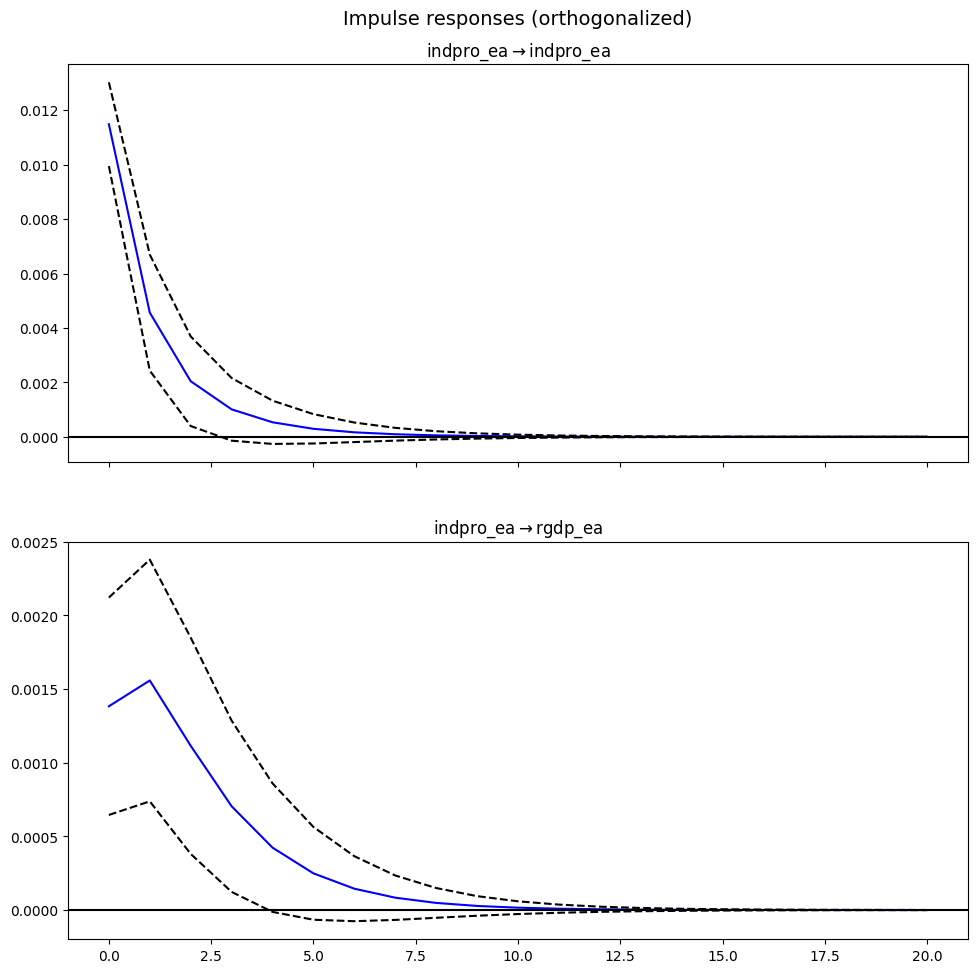

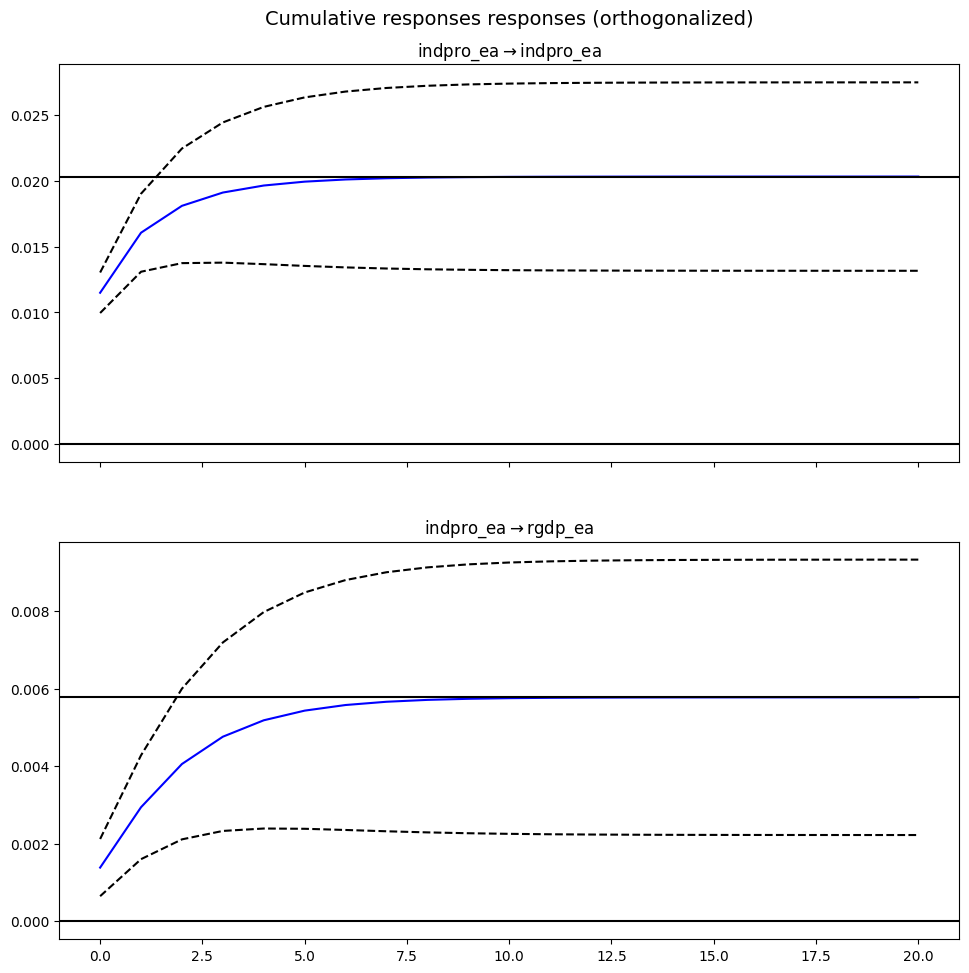

In [18]:
# Let us also inspect impulse responses 
# For the purpose of this excercise we assume indpro is "exogenous/driving force" for rGDP (weak assumption!), so we order it first 
Y_reordered = Y.iloc[:, ::-1]
var_full   = sm.tsa.VAR(Y_reordered)
res   = var_full.fit(1)

# compute impulse response functions for 5y
irf = res.irf(20)
# plot them assuming Cholesky decomposition - non-causal example
irf.plot(impulse = 'indpro_ea',orth=True);
irf.plot_cum_effects(impulse = 'indpro_ea', orth=True);

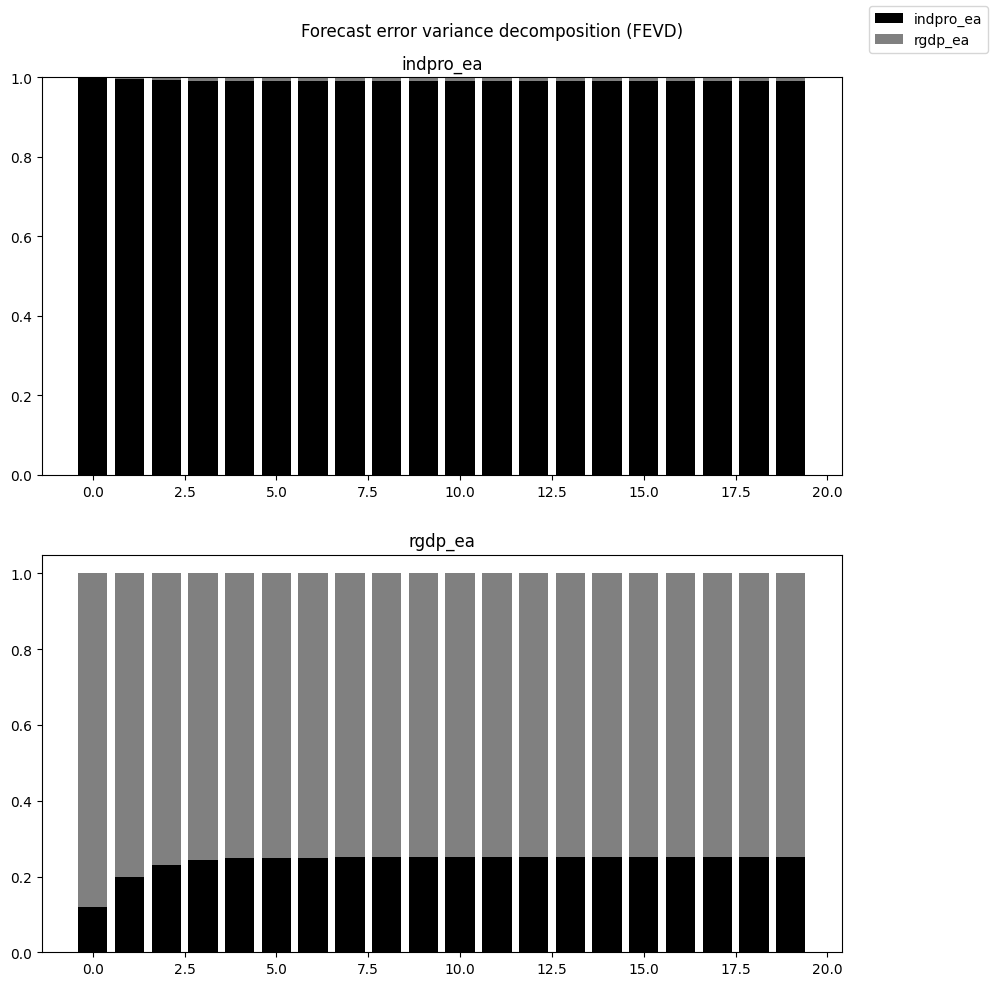

In [19]:
# FEVD
# What share of variability of rGDP is driven by shocks to industrial production? 
# fevd = res.fevd(20)
# fevd.summary()
res.fevd(20).plot();

